**Reviewer's comment:**
_The claim that FCC's are dependent on flux + enzyme data is supported by the ablation study that shows a clear accuracy drop when omitted. However, the lack of dependency on external metabolomics was only observed in simulations where perturbations were applied to enzyme concentrations. I am concerned this claim will not hold up in simulations where perturbations are applied to external nutrient conditions._


create TopB-noReg dataset with external metabolite perturbations. 
Compare v-based results of 
- topB-noReg-allData
1. topB-noReg-allData + external metabolite perturbations (this notebook)
- topB-noReg-omitExMet
2. topB-noReg-omitExMet + external metabolite perturbations

# Set up 

In [1]:
SEED = 1
import random

import tellurium as te
import pandas as pd
import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm

import cobra
import os

from scipy import stats
import scipy as sp
import math

import cloudpickle
import gzip

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
os.chdir('../../..')
from src import antemll, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyB/all_data/')

# Perturbing enzymes

In [3]:
ant ='../../../models/antimony/TopologyB.ant'  
r = te.loada(ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.7241056990445864e-15

In [4]:
pt_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 1.5, 3, 5, 7, 10]
pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x','0.5x', '1.5x', '3x', '5x', '7x', '10x']

In [5]:
data_file01 = '../../../data/generated_data/TopologyB-noReg-exMet/TopologyB_0.1.csv'
data_file02 = '../../../data/generated_data/TopologyB-noReg-exMet/TopologyB_0.2.csv'
data_file03 = '../../../data/generated_data/TopologyB-noReg-exMet/TopologyB_0.3.csv'
data_file04 = '../../../data/generated_data/TopologyB-noReg-exMet/TopologyB_0.4.csv'
data_file05 = '../../../data/generated_data/TopologyB-noReg-exMet/TopologyB_0.5.csv'

data_file15 = '../../../data/generated_data/TopologyB-noReg-exMet/TopologyB_1.5.csv'
data_file3 = '../../../data/generated_data/TopologyB-noReg-exMet/TopologyB_3.csv'
data_file5 = '../../../data/generated_data/TopologyB-noReg-exMet/TopologyB_5.csv'
data_file7 = '../../../data/generated_data/TopologyB-noReg-exMet/TopologyB_7.csv'
data_file100 = '../../../data/generated_data/TopologyB-noReg-exMet/TopologyB_10.csv'


In [6]:
BMCA_obj01 = antemll.antemll(ant, data_file01, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj02 = antemll.antemll(ant, data_file02, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj03 = antemll.antemll(ant, data_file03, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj04 = antemll.antemll(ant, data_file04, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj05 = antemll.antemll(ant, data_file05, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')

BMCA_obj15 = antemll.antemll(ant, data_file15, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj3 = antemll.antemll(ant, data_file3, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj5 = antemll.antemll(ant, data_file5, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj7 = antemll.antemll(ant, data_file7, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj100 = antemll.antemll(ant, data_file100, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


In [7]:
def run_prior_predictive(BMCA_obj):
    ll = emll.LinLogLeastNorm(BMCA_obj.N, BMCA_obj.Ex.to_numpy(), BMCA_obj.Ey.to_numpy(), BMCA_obj.v_star, driver='gelsy')
    
    with pm.Model() as pymc_model:
        # Initialize elasticities
        # Ex and Ey have to be shape (rxns, mets)
        Ex_t = pm.Deterministic('Ex', emll.util.initialize_elasticity(BMCA_obj.Ex.to_numpy().T, 'Ex', b=0.05, sd=1, alpha=5))
        Ey_t = pm.Deterministic('Ey', emll.util.initialize_elasticity(BMCA_obj.Ey.to_numpy().T, 'Ey', b=0.05, sd=1, alpha=5))

        trace_prior = pm.sample_prior_predictive(random_seed=SEED)

    return trace_prior

## Running ADVI

In [8]:
def run_ADVI(BMCA_obj):
    np.random.seed(SEED)
    random.seed(SEED)

    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 45000
    
    with pymc_model:
        advi = pm.ADVI(random_seed=SEED)
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-2), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    with pymc_model:
        trace = approx.sample(draws=1000, random_seed=SEED)
        ppc_vi = pm.sample_posterior_predictive(trace)

    return trace, ppc_vi

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,690
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,501.4
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,419.7
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,372.3
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,336.6
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,294.8
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,484.5
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,769.7
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,179
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3,020.6
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


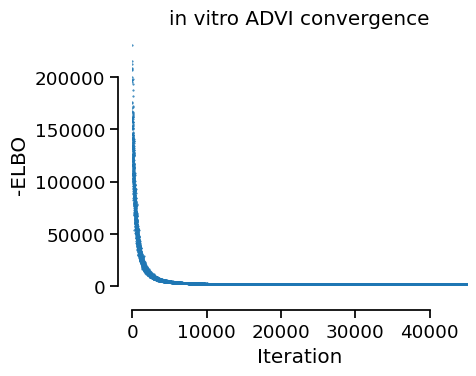

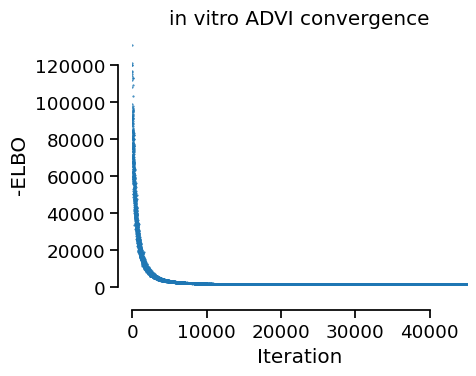

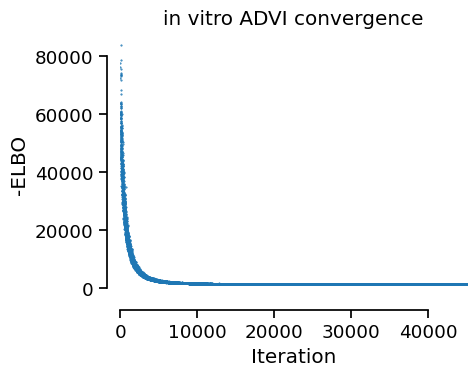

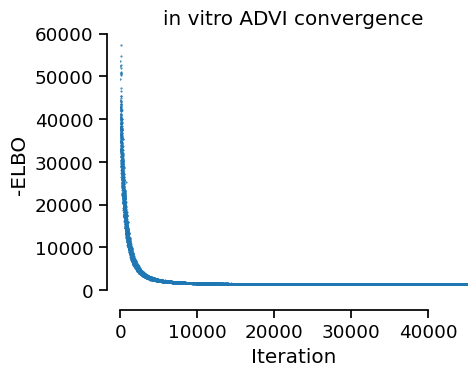

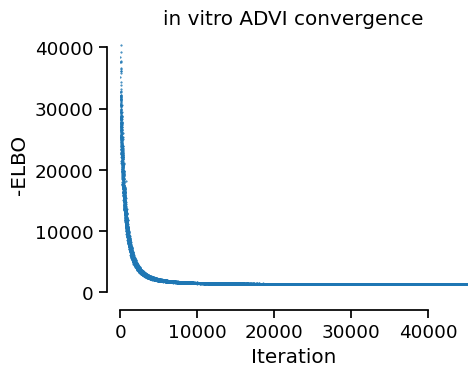

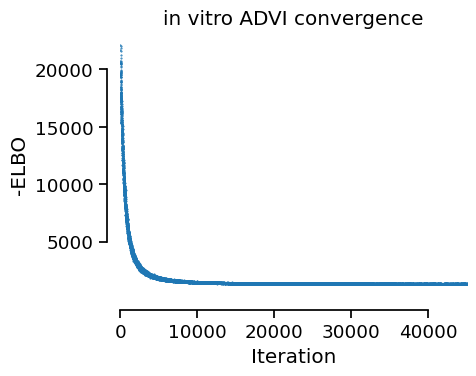

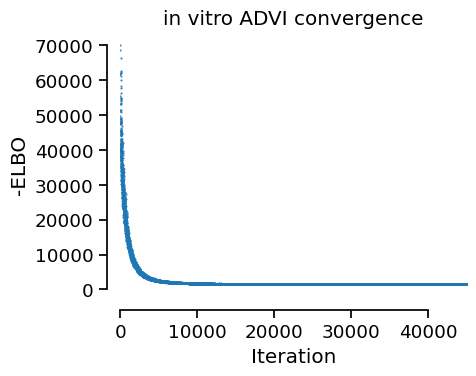

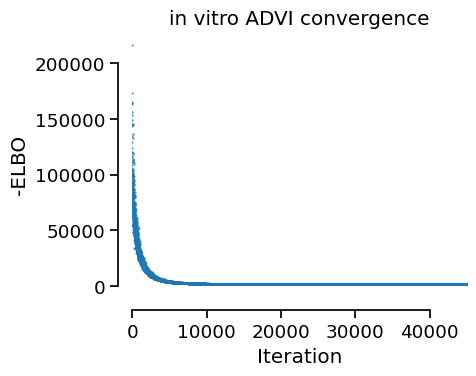

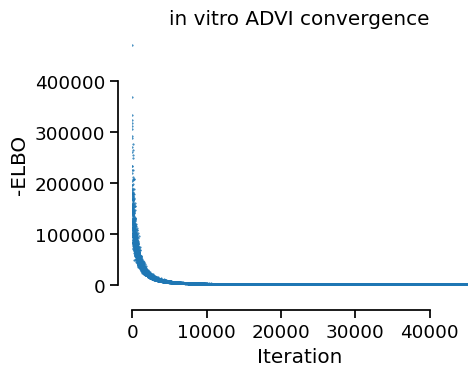

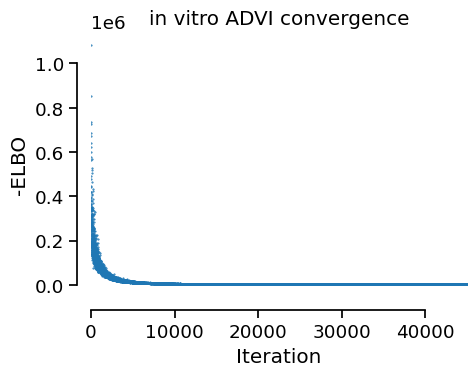

In [9]:
trace01, ppc01 = run_ADVI(BMCA_obj01)
trace02, ppc02 = run_ADVI(BMCA_obj02)
trace03, ppc03 = run_ADVI(BMCA_obj03)
trace04, ppc04 = run_ADVI(BMCA_obj04)
trace05, ppc05 = run_ADVI(BMCA_obj05)

trace15, ppc15 = run_ADVI(BMCA_obj15)
trace3, ppc3 = run_ADVI(BMCA_obj3)
trace5, ppc5 = run_ADVI(BMCA_obj5)
trace7, ppc7 = run_ADVI(BMCA_obj7)
trace100, ppc100 = run_ADVI(BMCA_obj100)

### saving trace data

In [10]:
with gzip.open("../../../data/results/picklejar/dandelion-1.pgz", "wb") as f:
            cloudpickle.dump(
                {
                "trace01":trace01,
                "trace02":trace02,
                "trace03":trace03,
                "trace04":trace04,
                "trace05":trace05,
                "trace15":trace15,
                "trace3":trace3,
                "trace5":trace5,
                "trace7":trace7,
                "trace100":trace100,
                "ppc01":ppc01,
                "ppc02":ppc02,
                "ppc03":ppc03,
                "ppc04":ppc04,
                "ppc05":ppc05,
                "ppc15":ppc15,
                "ppc3":ppc3,
                "ppc5":ppc5,
                "ppc7":ppc7,
                "ppc100":ppc100
                },
                f,
            )

_go to `dandelion-stats.ipynb` and run that notebook for the results_